# Usage Example

This notebook presents usage of the hybrid modelling with kernel regression and neural network with theoretical bounds.

In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
from matplotlib import pyplot as plt
import lightning.pytorch as pl
from sklearn import metrics
from sklearn.model_selection import train_test_split

from src.models.kernel import NumpyKernelRegression
from src.models.hybrid import HybridResidualModule

Set constant parameters of the experiment

In [2]:
n = 500  # number of samples
L = 2  # Lipschitz constant
NOISE_VARIANCE = 0.1 # noise variance

limits = np.array([[0], [4 * np.pi]])  # domain
grid_step = np.array([0.05])  # grid step for test data

sns.set()

### Data

Example target function, composed of 5 sine waves with different frequencies.

In [3]:
def target(x):
    return np.sum([np.sin(freq * x) for freq in [1, 2, 6, 10, 12]], axis=0) / 5


def generate_data(nonlinear, limits, n_samples: int, noise_variance: float):
    dims = limits.shape[-1]

    x = np.random.normal(0, 1, (n_samples, dims))
    noise = np.random.normal(0, noise_variance, size=[n_samples, dims])
    y = nonlinear(*np.split(x, dims, axis=-1)) + noise

    return x, y  # type: ignore

In [4]:
train_x, train_y = generate_data(target, limits=limits, n_samples=n, noise_variance=NOISE_VARIANCE)

### Split

Data can be split into two subset: training kernel regression and residual neural network. In experiments the same data can be used for training both, to avoid reducing the number of samples. Following code splits the training into equally sized subsets. 

*Note*: Test data will be generated later.

In [5]:
kr_index, nn_index = train_test_split(np.arange(len(train_x)), test_size=0.5)  # test size is network training size

# split train data into two subset for network training and kernel regression
kr_train_x, nn_train_x = train_x[kr_index], train_x[nn_index]
kr_train_y, nn_train_y = train_y[kr_index], train_y[nn_index]

In [6]:
nw_train_x = torch.from_numpy(kr_train_x).to(torch.float32)
nn_train_x = torch.from_numpy(nn_train_x).to(torch.float32)

nw_train_y = torch.from_numpy(kr_train_y).to(torch.float32)
nn_train_y = torch.from_numpy(nn_train_y).to(torch.float32)

### Models

Defined simple neural network (current example has just 61 parameters).

In [7]:
network = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=20),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=20, out_features=20),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=20, out_features=1),
)

In [8]:
hybrid_model = HybridResidualModule(network, bandwidth=0.15, delta=0.1, lipschitz_constant=L, noise_variance=NOISE_VARIANCE, residual_zero_init=False)

In [9]:
hybrid_train_x = torch.from_numpy(train_x).to(torch.float32)  # in this experiment the training subset split is not used
hybrid_train_y = torch.from_numpy(train_y).to(torch.float32)

hybrid_model.adapt(hybrid_train_x, hybrid_train_y)

Create `pl.LightningModule` for training to avoid writing redundant code. Current implementation is using basic MSE and Adam optimizer.

In [10]:
class LightningModule(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = torch.nn.functional.mse_loss(y_hat, y)
        
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = torch.nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.2, min_lr=1e-5)
    
        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler, "monitor": "val_loss"}

### Training

In [11]:
callbacks = [pl.callbacks.EarlyStopping(monitor="val_loss", patience=500, mode="min")]
trainer = pl.Trainer(max_epochs=1000, logger=False, callbacks=callbacks, enable_progress_bar=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
train_index, val_index = train_test_split(np.arange(len(hybrid_train_x)), test_size=0.1)  # 10% validation split

train_x, val_x = hybrid_train_x[train_index, :], hybrid_train_x[val_index, :]
train_y, val_y = hybrid_train_y[train_index, :], hybrid_train_y[val_index, :]

In [13]:
train_data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_x, train_y), batch_size=16, num_workers=0)
val_data_laoder = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(val_x, val_y), batch_size=16, num_workers=0)

trainer.fit(LightningModule(hybrid_model), train_data_loader, val_data_laoder)

/mnt/c/Users/kzaja/Documents/Research/Github/pydentification/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:630: Checkpoint directory /mnt/c/Users/kzaja/Documents/Research/Github/nn-with-nwb/checkpoints exists and is not empty.

  | Name  | Type                 | Params
-----------------------------------------------
0 | model | HybridResidualModule | 481   
-----------------------------------------------
481       Trainable params
0         Non-trainable params
481       Total params
0.002     Total estimated model params size (MB)


/mnt/c/Users/kzaja/Documents/Research/Github/pydentification/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/mnt/c/Users/kzaja/Documents/Research/Github/pydentification/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


### Test

Test using 1000 newly generated samples from the target function.

In [14]:
test_x = np.linspace(-2 * train_x.std(), 2 * train_x.std(), 1000)

test_tensor = torch.from_numpy(test_x).unsqueeze(dim=-1).to(torch.float32)

y_pred = trainer.model(test_tensor)
y_pred = y_pred.detach().numpy().flatten()

In [15]:
estimator = NumpyKernelRegression(bandwidth=0.15)  # compare with kernel regression with the same bandwidth
estimator.fit(train_x, train_y)

In [16]:
y_reference, bounds = estimator.predict(np.expand_dims(test_x, axis=-1), with_bounds=True, delta=0.1, lipschitz_constant=L, noise_variance=NOISE_VARIANCE)

y_lower = y_reference - bounds
y_upper = y_reference + bounds

Sanity check on the network output, when it predicts mostly zeros, this means network and kernel regression converge and mostly KR predictions are used. For larger values, the network will contribute a correction, for really large values, the predictions will probably be from lower or upper bounds.

In [17]:
test_tensor = torch.from_numpy(test_x).unsqueeze(dim=-1).to(torch.float32)

net_predictions = hybrid_model.network(test_tensor)
net_predictions = net_predictions.detach().numpy().flatten()

net_predictions.mean(), net_predictions.std()

(-0.004234584, 0.0070552453)

### Evaluate

In [18]:
kr_mse = metrics.mean_absolute_error(y_reference.flatten(), target(test_x).flatten())
nn_mse = metrics.mean_absolute_error(y_pred.flatten(), target(test_x).flatten())

In [19]:
print(f"KR: {kr_mse:.4f}")
print(f"NN: {nn_mse:.4f}")
print(f"DIFF: {abs(kr_mse - nn_mse) / max(kr_mse, nn_mse):.2%}")

KR: 0.0716
NN: 0.0691
DIFF: 3.43%


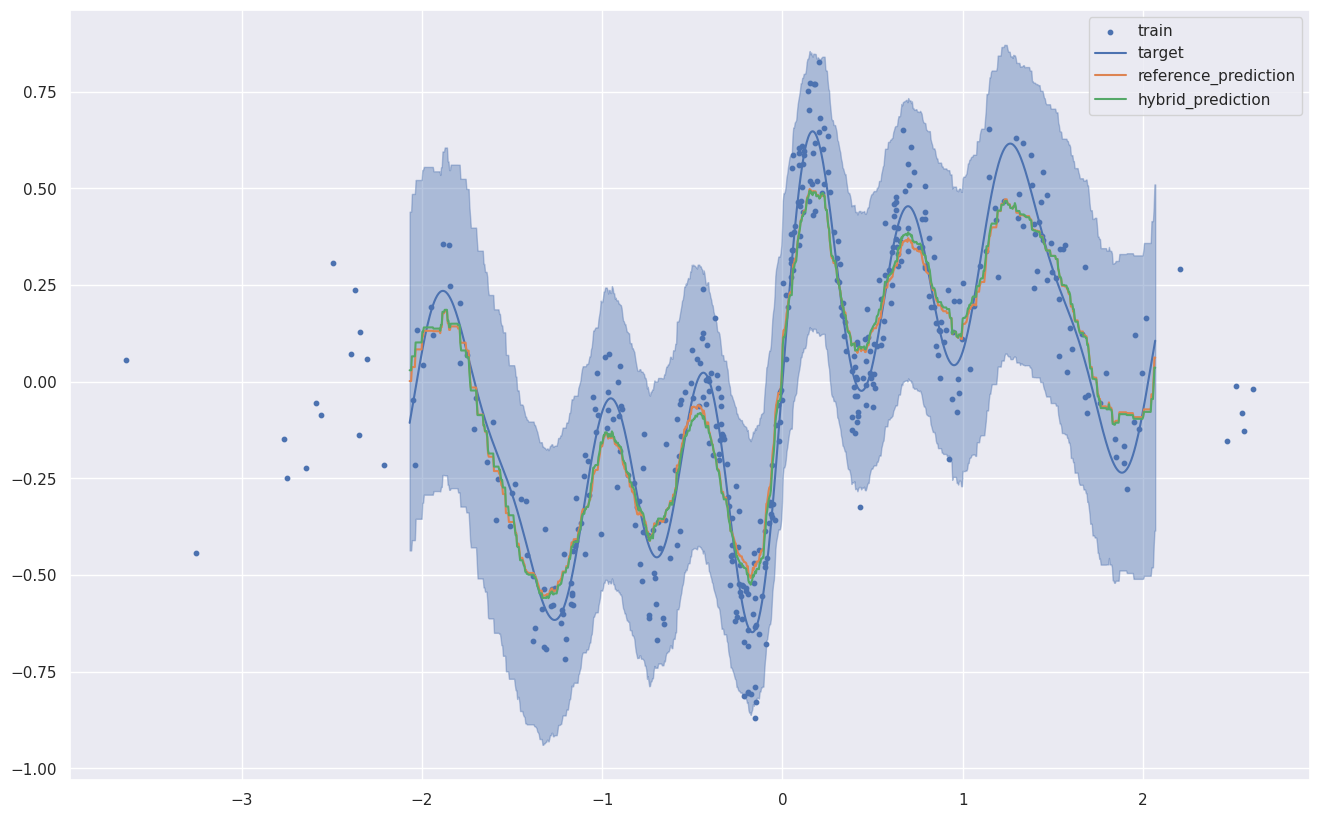

In [20]:
plt.figure(figsize=(16, 10))

plt.scatter(train_x, train_y, label="train", s=10)
plt.plot(test_x, target(test_x), label="target")
plt.plot(test_x, y_reference, label="reference_prediction")
plt.plot(test_x, y_pred, label="hybrid_prediction")
plt.fill_between(test_x.flatten(), y_lower.flatten(), y_upper.flatten(), alpha=0.4, color="C0")

plt.legend()
print()